 # Función de correlación anisotrópica


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

### Estimadores de la función de correlación

El estimador que usaremos es el siguiente:

#### Estimador de Correlación Landy-Szalay

$\xi_{LZ}^2 = 1+\frac{1}{N_{est}^2}\frac{DD}{RR}-2\frac{1}{N_{est}}\frac{DR(r)}{RR(r)}  $

In [2]:
# Estimador de Landy-Szalay  ND,NR numero de datos y datos random, 
# DD,RR,DR son los valores obtenidos en el histograma para cada bin de distancia.

def landy(ND,NR,DD,RR,DR):
    ND = ND*1.
    NR = NR*1.
    Nest2 = ND*(ND-1)/(NR*(NR-1))
    return 1+(DD/(RR*Nest2))-(2*DR/(RR*Nest2**.5))



In [3]:
# Función con lo que se obtiene una distribución uniforme de una caja de lado L,
# dim es la dimesion para 2D o 3D, N es el numero de datos
def caja(dim,L,N):
    return np.random.random((dim, N))*L-0.5*L

In [4]:
# Función con lo que se obtiene una distribución uniforme de un anillo

# Input values: r es el radio mayor, r1 el radio menor, N numero de puntos
def anillo(r,r1,N):
    anillo = []
    i=0
    dim=2
    # Ciclo que obtiene N puntos dentro de un circulo o esfera
    while i<N:
        point = np.random.random(dim)*2*r-r # Se crea el punto
        r_test = (point**2).sum(axis=0)**.5 
        # Se guarda el punto si el punto esta dentro de el circulo
        if (r_test <= r and r_test >= r1 ):
            anillo.append(point)
            i+=1
    anillo = np.array(anillo)
    anillo = anillo.T
    return anillo # Regresa los punos dentro del circulo

In [4]:
# Función con lo que se obtiene la distancia entre los puntos de la distribución

# Input values: N dimension, D son los datos, R datos random, 
# bins los intervalos, tipo es DD,RR,DR
def distancia(N,D,R,bins,tipo):
    
    if (tipo == 'DD' or tipo == 'RR'):
        # Obteniendo el arreglo de distancias
        dist = D[:,None] - D[...,None] # resta todas las combinaciones y los almacena en dos matrices una para cada renglon
        dist = (dist**2).sum(axis=0)**.5 # axis=0, asegura que use los datos de cada renglon, y no las columnas. Devuelve una matriz triangular
        dist = dist[np.triu_indices(N, k = 1)] # extrae el tringulo superior (puede ser el inferior pq es simetrica), hay q especificar el número N
    
    if tipo == 'DR':
        dist = D[:,None] - R[...,None]
        dist = (dist**2).sum(axis=0)**.5
        dist = dist.flatten() # Regresa las frecuencias en un arreglo de 1 dimensión
        
    #Histograma
    
    count, bins, ignored_D = plt.hist(dist,bins = bins,edgecolor = 'black',  linewidth=1)
    plt.title('Histograma de distancias datos %s'%tipo)
    plt.legend()
    return dist, count # Regresa laS distancias, y las frecuencias del histograma

In [289]:
# Función para obtener el anillo deformado por las velocidades que dependen de la 
# distancia minima (x,y)--> (x,y+d_min*f_scale)

def corrimiento(D,f_scale):
    # Haciendo una copia de los datos donde guardaremos los datos corridos de D.
    D_shift = D.copy()
    # En este for encontraremos la distancia mínima para cada punto en D.
    for i in range(np.shape(D)[1]): # número de datos de D
        d_min = np.infty # d_vel es la variable donde guardaremos la distancia minima
        for j in range(np.shape(D)[1]): # número de datos de D
            if i!=j: # Para no obtener distancias igual a cero
                # Calculando la distancia entre el punto i e j
                d_test=np.sqrt((D[0][i] - D[0][j])**2 + (D[1][i]-D[1][j])**2)
                # Condicion de que la distancia sea menor que una vecidad L/10
                if (d_test < L/10 and d_min > d_test):
                    # Actualiza el valor minimo de distancia 
                    d_min = d_test
                    # Modifcamos la posicion en 'y' para el punto i
                    D_shift[1][i] = D[1][i] + d_min*f_scale
    return D_shift

In [294]:
# Funcion para obtener las componentes x e y
def distancia_xy(D,R,tipo):
    dx =[]
    dy =[]
        
    #Histograma
    for i in range(np.shape(D)[1]): # número de datos de D
        for j in range(np.shape(D)[1]): # número de datos de D
            # Calculando la distancia entre el punto i e j
            if (tipo == 'DD' or tipo == 'RR'):
                if i != j :
                    xc=D[0][j]-D[0][i]
                    yc=D[1][j]-D[1][i]
                    dx.append(xc)
                    dy.append(yc)
            elif(tipo == 'DR'):
                xc=D[0][j]-R[0][i]
                yc=D[1][j]-R[1][i]
                dx.append(xc)
                dy.append(yc)
    dx=np.array(dx)
    dy=np.array(dy)
    return dx,dy
    #return np.absolute(dx),np.absolute(dy)

In [310]:
# Definiendo funcion para histograma de componentes x y y de las distancias de D, nbins numero de bins del histograma
def histdxdy(dx,dy,nbin):
    # Ajustando el numero de bins para la matriz del histograma
    nbin = nbin+1
    # Definiendo bins para el histograma usando valores minimo y maximo de dy
    binxy = np.linspace(min(dy),max(dy),nbin)
    # Definimos un arreglo de nbin x nbin para guardar los valores del histograma poniendo 0 en todas sus entradas
    h= np.random.rand(len(binxy)-1,len(binxy)-1)*0
    # En este for vamos a sumar dx y dy caen en los bins binx,biny 
    for i in range(len(dx)):
        for j in range(len(binxy)):
            if j<len(binxy)-1:
                if (binxy[j]< dx[i] < binxy[j+1]):
                    binx = j
                if (binxy[j]< dy[i] < binxy[j+1]):
                    biny = j
        # Sumamos uno en la matriz del histograma para dx y dy
        h[binx][biny]+=1
    # Graficando histograma de h
    plt.imshow(h) 
    plt.colorbar() 
    plt.show()
    print "Las componentes X y Y del histograma corresponen al numero de bins en que se dividio la distancia que va de:", min(dy),' a ', max(dy)
    return h
        
            

### Aplicando las definiciones para un anillo obtendremos el histograma en 2D

In [287]:
r,r1,L,ND,NR= 5,4,15,1000,5000
bins = np.linspace(0,2*r,100)
dim = 2 # dimension de la caja

# Generando Datos normales,su corrimiento y datos random
D = anillo(r,r1,ND)
D_shift = corrimiento(D,0.1)
R = caja(2,L,NR)

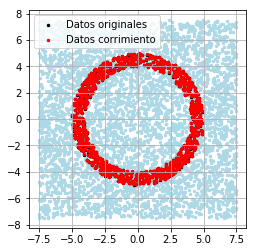

In [328]:
# Graficando los datos originales y los datos con corrimiento
x,y = D
xc,yc = D_shift
xr,yr =R
plt.clf()
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(xr,yr,color='lightblue',s=6)
ax.scatter(x,y,color='k',s=6,label='Datos originales')
ax.scatter(xc,yc,color='r',s=6,label='Datos corrimiento')
ax.grid()
plt.legend()
plt.show()

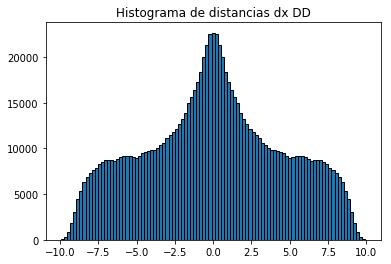

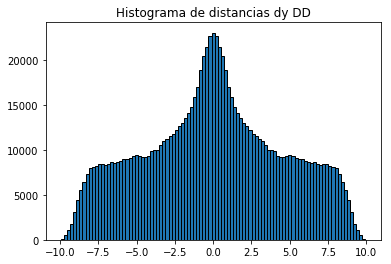

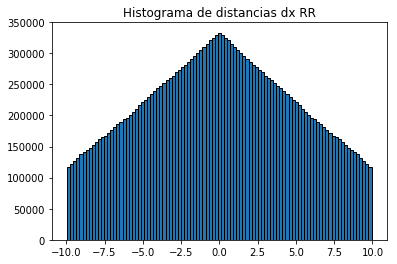

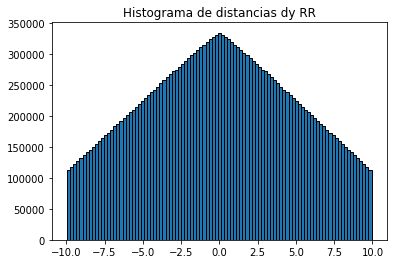

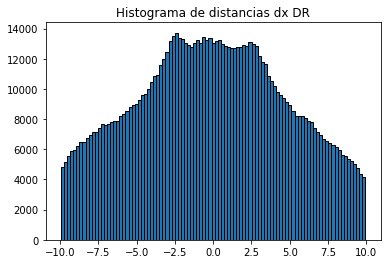

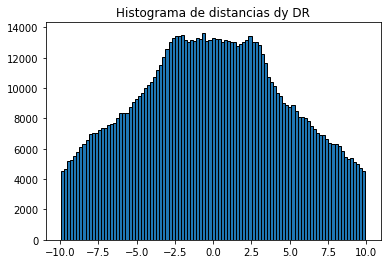

In [319]:
# Obteniendo componentes X y Y para datos y datos random, sus histogramas y funciones de correlación
dx,dy = distancia_xy(D_shift,None,'DD')
dx_r,dy_r = distancia_xy(R,None,'RR')
dx_DR,dy_DR = distancia_xy(D,R,'DR')

bins = np.linspace(min(dy),max(dy),100)
# Histogramas 
DDX, bins, ignored_D = plt.hist(dx,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dx DD')
plt.show()

DDY, bins, ignored_D = plt.hist(dy,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dy DD')
plt.show()

RRX, bins, ignored_D = plt.hist(dx_r,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dx RR')
plt.show()

RRY, bins, ignored_D = plt.hist(dy_r,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dy RR')
plt.show()

DRX, bins, ignored_D = plt.hist(dx_DR,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dx DR')
plt.show()

DRY, bins, ignored_D = plt.hist(dy_DR,bins = bins,edgecolor = 'black',  linewidth=1)
plt.title('Histograma de distancias dy DR')
plt.show()

In [315]:
len(dx_r)

24995000

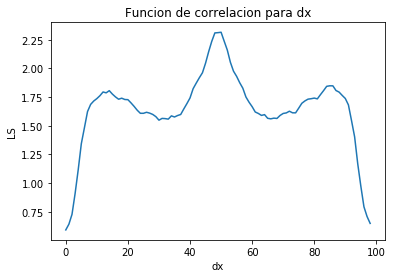

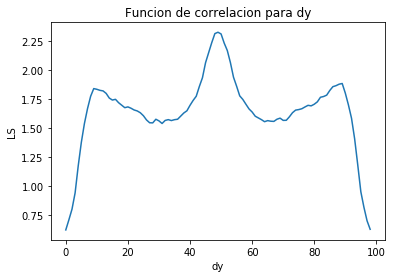

In [323]:
# Graficando funciones de correlación usando estimador Landy

plt.plot(landy(ND,NR,DDX,RRX,DRX))
plt.title('Funcion de correlacion para dx')
plt.xlabel('dx')
plt.ylabel('LS')
plt.show()

plt.plot(landy(ND,NR,DDY,RRY,DRY))
plt.title('Funcion de correlacion para dy')
plt.xlabel('dy')
plt.ylabel('LS')
plt.show()

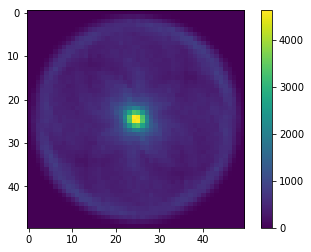

Las componentes X y Y del histograma corresponen al numero de bins en que se dividio la distancia que va de: -9.94220340054  a  9.94220340054


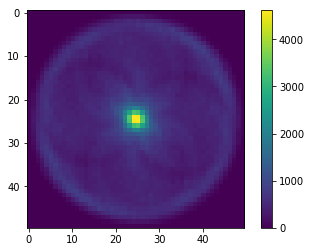

Las componentes X y Y del histograma corresponen al numero de bins en que se dividio la distancia que va de: -9.93786521214  a  9.93786521214


In [324]:
# Ahora vamos a graficar los histogramas dx y dy para los datos originales y los datos corridos.

dx_o,dy_o = distancia_xy(D,None,'DD')
h_original = histdxdy(dx_o,dy_o,50)

h_shift = histdxdy(dx,dy,50)

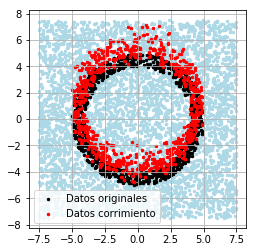

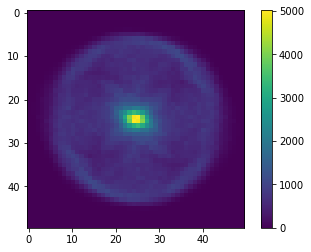

Las componentes X y Y del histograma corresponen al numero de bins en que se dividio la distancia que va de: -11.9435004777  a  11.9435004777
Histograma dx,dy para datos con corrimiento


In [329]:
# Probando con un factor de corrimiento más grande

D_shift10 = corrimiento(D,10.)
dx10,dy10 = distancia_xy(D_shift10,None,'DD')

# Graficando los datos originales y los datos con corrimiento
x,y = D
xc,yc = D_shift10
xr,yr =R
plt.clf()
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(xr,yr,color='lightblue',s=6)
ax.scatter(x,y,color='k',s=6,label='Datos originales')
ax.scatter(xc,yc,color='r',s=6,label='Datos corrimiento')
ax.grid()
plt.legend()
plt.show()

# Histograma dx dy
histdxdy(dx10,dy10,50)
plt.show()
print 'Histograma dx,dy para datos con corrimiento'